In [15]:
path_to_video = "/mnt/750G/data/v2/video_540ss/"

In [16]:
from pathlib import Path

data_path = Path(path_to_video)

print(data_path)

image_path_list = list(data_path.glob("*.mp4"))

/mnt/750G/data/v2/video_540ss


In [17]:
image_path_list[1]

PosixPath('/mnt/750G/data/v2/video_540ss/0091e812-f56f-4bd9-ad65-019fc97c1ffe.mp4')

In [18]:
import os
import torch                                    # type: ignore
import random
import itertools
import torch.utils                              # type: ignore
import torch.utils.data                         # type: ignore
from torchvision.io import VideoReader          # type: ignore
from torchvision.transforms import transforms as T # type: ignore
from torchvision.datasets.folder import make_dataset # type: ignore
torch.backends.cuda.matmul.allow_tf32 = True

In [7]:
import numpy as np                              # type: ignore
import pandas as pd                             # type: ignore
import matplotlib.pyplot as plt                 # type: ignore

import torch                                    # type: ignore
from torch import nn, optim                     # type: ignore
import torch.nn.functional as F                 # type: ignore
from torchvision import datasets, transforms    # type: ignore
from torchvision.utils import save_image        # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
from torch.autograd import Variable             # type: ignore

import cv2                                      # type: ignore
from PIL import Image                           # type: ignore

In [8]:
from hashlib import md5
from progress.bar import IncrementalBar         # type: ignore

In [8]:
# import open cv
import cv2

for i in range(20):
    # load the video using path of video ( my video length is 37 sec )
    video_path = image_path_list[i+40].__str__() 
    video = cv2.VideoCapture(video_path)

    success = True
    count = 1
    image_id = 1
    while success:
        success , frame = video.read()
        if success == True:
            
            
            # i want every 5th frame from video
            # thats why i used following line of code
            # i dont want all frames from video
            # so we can decide the outpt frames count according to us.
            
            if count%5 == 0:
                
                # specify the output path and file name
                # i used count as a file name
                # you can use any
                name = str(md5(frame).hexdigest()[:10])+".jpg"
                image_id += 1
                # save the image
                cv2.imwrite(os.path.join('/home/qwest/data_for_ml/ego4d/' , name),frame)
            count += 1
        else:
            break

    print("Total Extracted Frames :",image_id) 

Total Extracted Frames : 14650
Total Extracted Frames : 423
Total Extracted Frames : 11165
Total Extracted Frames : 20251
Total Extracted Frames : 15657
Total Extracted Frames : 13382
Total Extracted Frames : 10693
Total Extracted Frames : 13866
Total Extracted Frames : 4820
Total Extracted Frames : 25604
Total Extracted Frames : 5349
Total Extracted Frames : 6152
Total Extracted Frames : 12020
Total Extracted Frames : 4027
Total Extracted Frames : 5557
Total Extracted Frames : 10705
Total Extracted Frames : 25286
Total Extracted Frames : 7817
Total Extracted Frames : 6336
Total Extracted Frames : 4229


In [9]:
stream = "video"
video = VideoReader(image_path_list[1].__str__(), stream)
video.get_metadata()

{'video': {'fps': [30.0], 'duration': [1896.9666666666667]},
 'audio': {'framerate': [48000.0], 'duration': [1896.98]}}

In [10]:
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
class Ego4d(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
            
            #img.save(f'/home/qwest/data_for_ml/60x60/{img_name}')
            #print({img_name})
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)
        

In [12]:
# First preprocessing of data
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
#random_transforms = [transforms.RandomRotation(degrees=10)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 #transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/60x60/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=14)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_loader init


In [14]:
import plotly.express as p
x = next(iter(train_loader))
x = x[1].permute(1, 2, 0)
f = p.imshow(x)
f.show()

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128, no_of_sample=10, batch_size=32, channels=3):
        super(VAE, self).__init__()
        
        self.no_of_sample = no_of_sample
        self.batch_size = batch_size
        self.channels = channels
        self.latent_dim = latent_dim
        
        
        # Encoder
        def convlayer_enc(n_input, n_output, k_size=4, stride=2, padding=1, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block
        
        self.encoder = nn.Sequential(
            *convlayer_enc(self.channels, 64, 4, 2, 2),               # (64, 32, 32)
            *convlayer_enc(64, 128, 4, 2, 2),                         # (128, 16, 16)
            *convlayer_enc(128, 256, 4, 2, 2, bn=True),               # (256, 8, 8)
            *convlayer_enc(256, 512, 4, 2, 2, bn=True),               # (512, 4, 4)
            nn.Conv2d(512, self.latent_dim*2, 4, 1, 1, bias=False),   # (latent_dim*2, 4, 4)
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        
        # Decoder
        def convlayer_dec(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block
        
        self.decoder = nn.Sequential(
            *convlayer_dec(self.latent_dim, 512, 4, 2, 1),           # (512, 8, 8)
            *convlayer_dec(512, 256, 4, 2, 1),                       # (256, 16, 16)
            *convlayer_dec(256, 128, 4, 2, 1),                       # (128, 32, 32)
            *convlayer_dec(128, 64, 4, 2, 1),                        # (64, 64, 64)
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),          # (3, 64, 64)
            nn.Sigmoid()
        )

    def encode(self, x):
        '''return mu_z and logvar_z'''
        x = self.encoder(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]
    
    def decode(self, z):
        z = self.decoder(z)
        return z.view(-1, 3 * 64 * 64)

    def reparameterize(self, mu, logvar):
        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation

            sample_z = []
            for _ in range(self.no_of_sample):
                std = logvar.mul(0.5).exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))
            return sample_z
        
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 3 * 64 * 64))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 3 * 64 * 64))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= self.batch_size * 3 * 64 * 64

        return BCE + KLD

In [14]:
lr = 0.001
epochs = 50
latent_dim = 32

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
for epoch in range(1, epochs+1):
    x = next(iter(train_loader))
    model.train()
    print(f'Epoch {epoch} start')
    
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()
        
    model.eval()
    recon_img, _, _ = model(x[:1].to(device))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
    
    f = p.imshow(img)
    f.show()

Epoch 1 start


KeyboardInterrupt: 

In [41]:
torch.save(model.state_dict(), "VAE.pth")

In [16]:
model = VAE(latent_dim, batch_size=batch_size).to(device)
model = torch.load(f"/home/qwest/VAE_weight/VAE9.pth")
model.eval()

/tmp/ipykernel_9530/2896512309.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), 

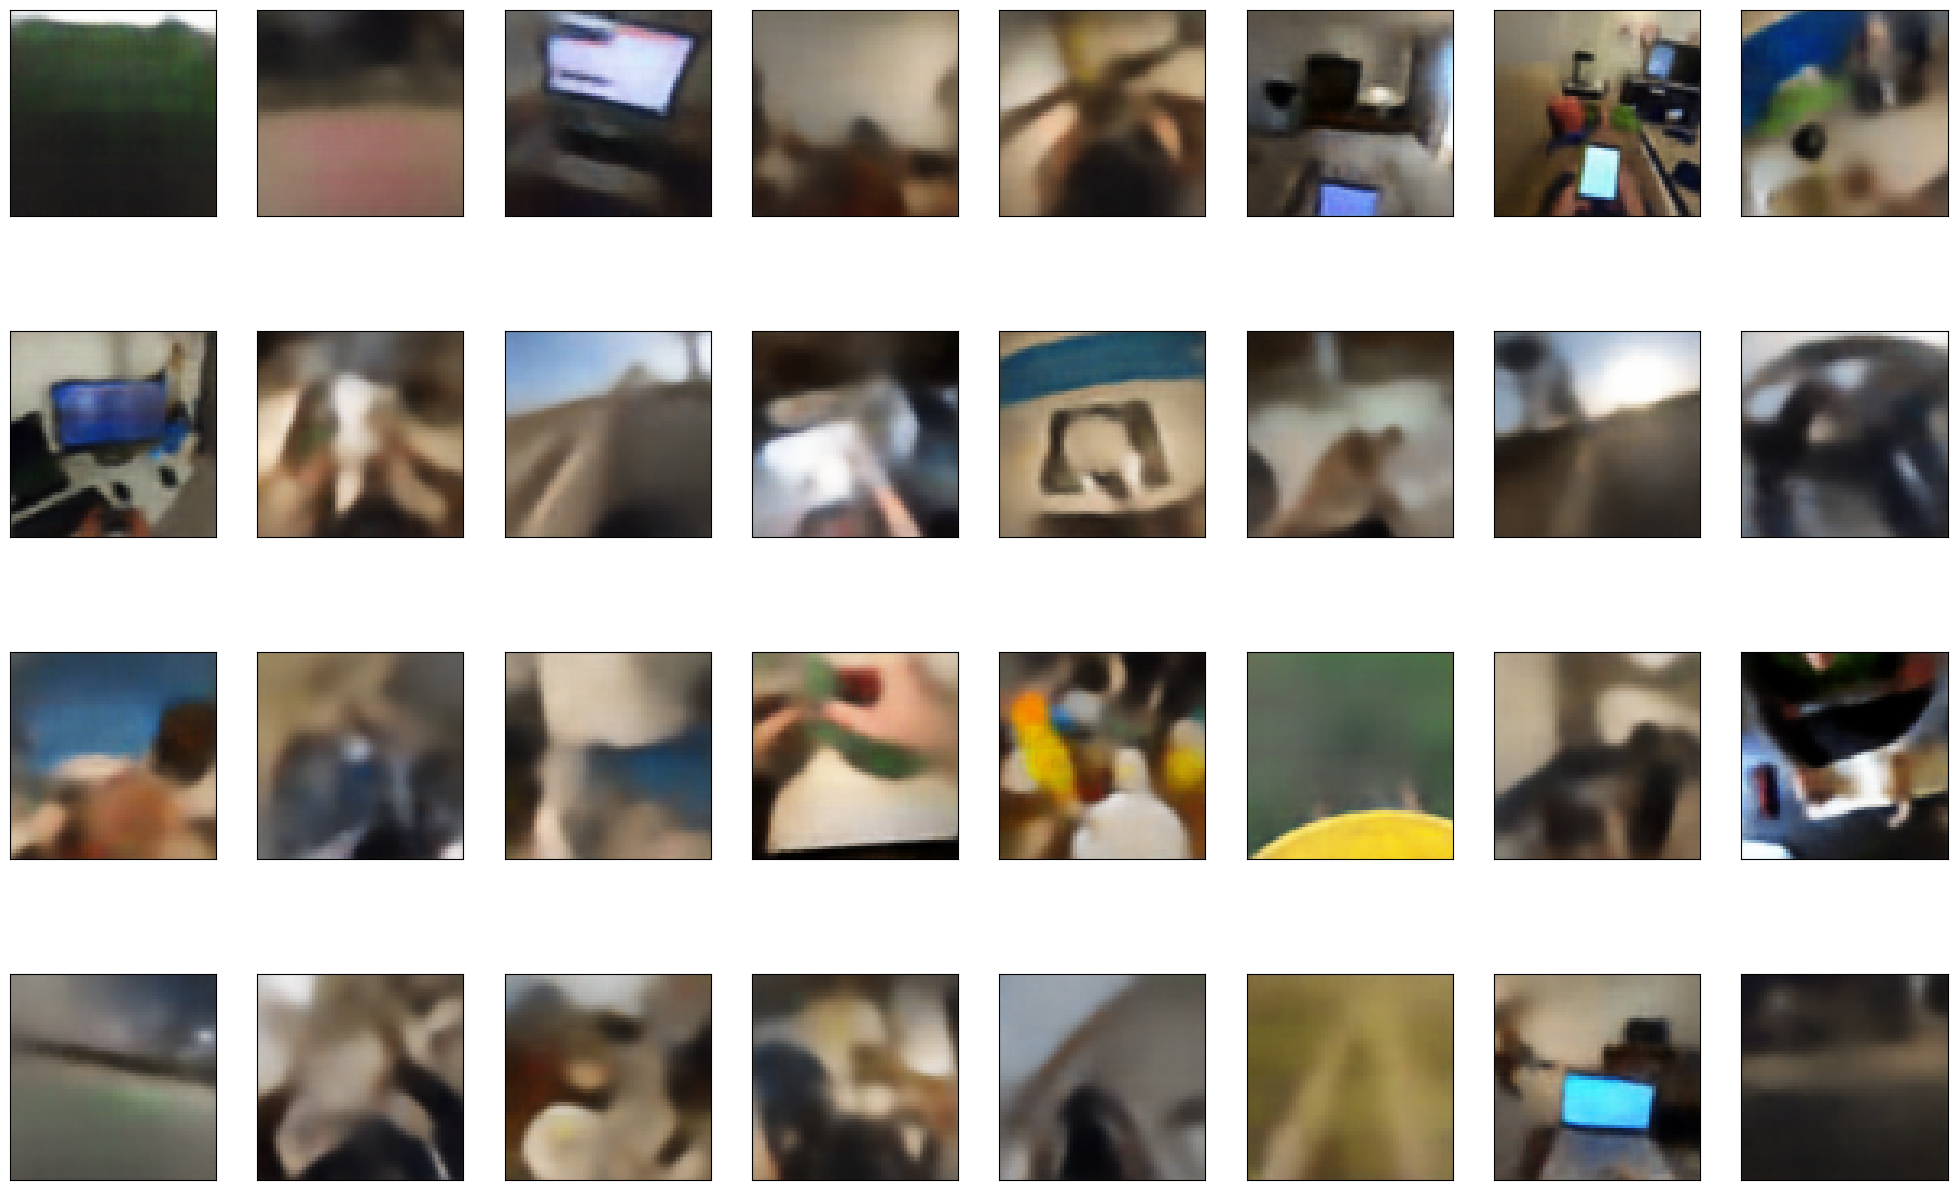

In [17]:
x = next(iter(train_loader))
reconstructed, mu, _ = model(x.to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

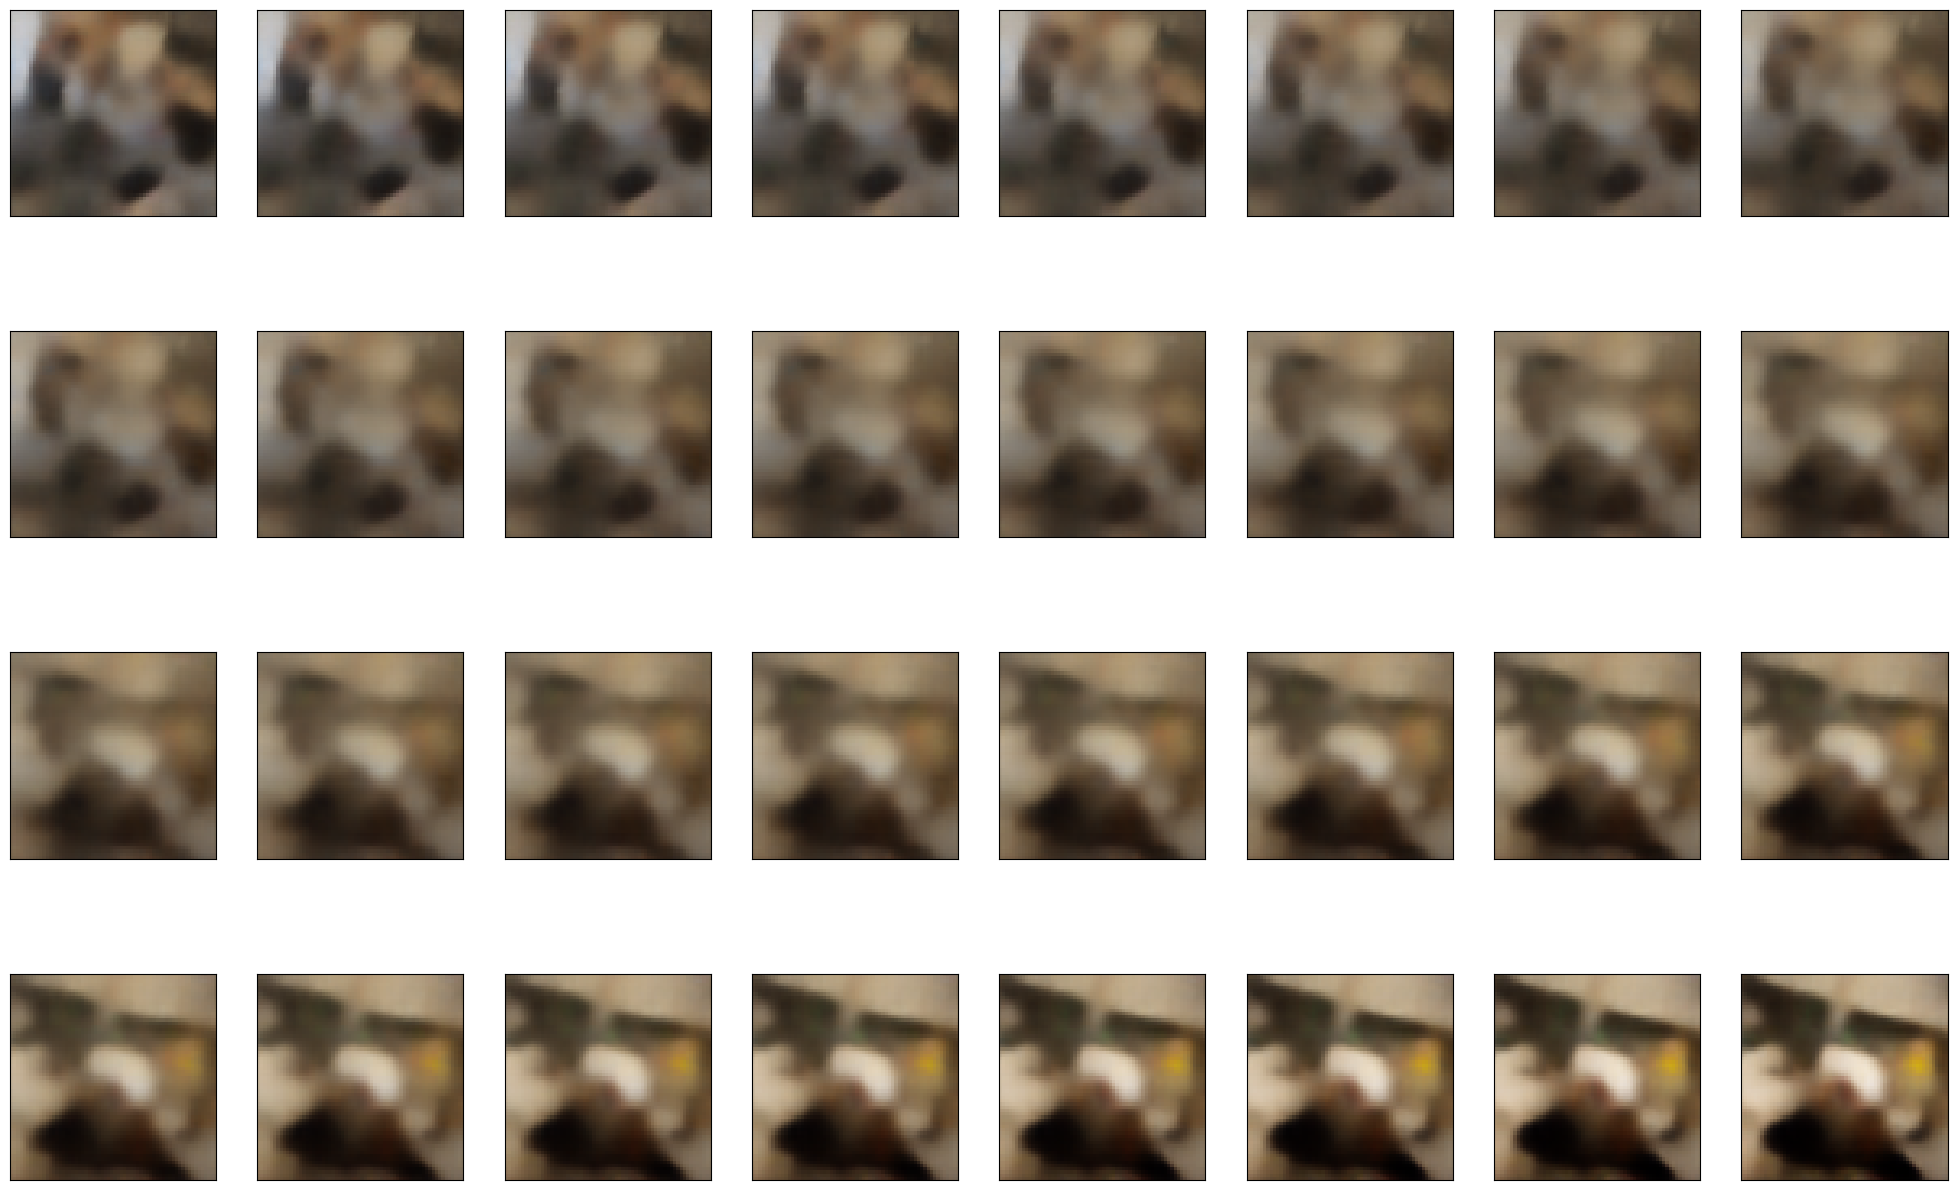

In [61]:
first_dog_idx = 1
second_dog_idx = 3

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

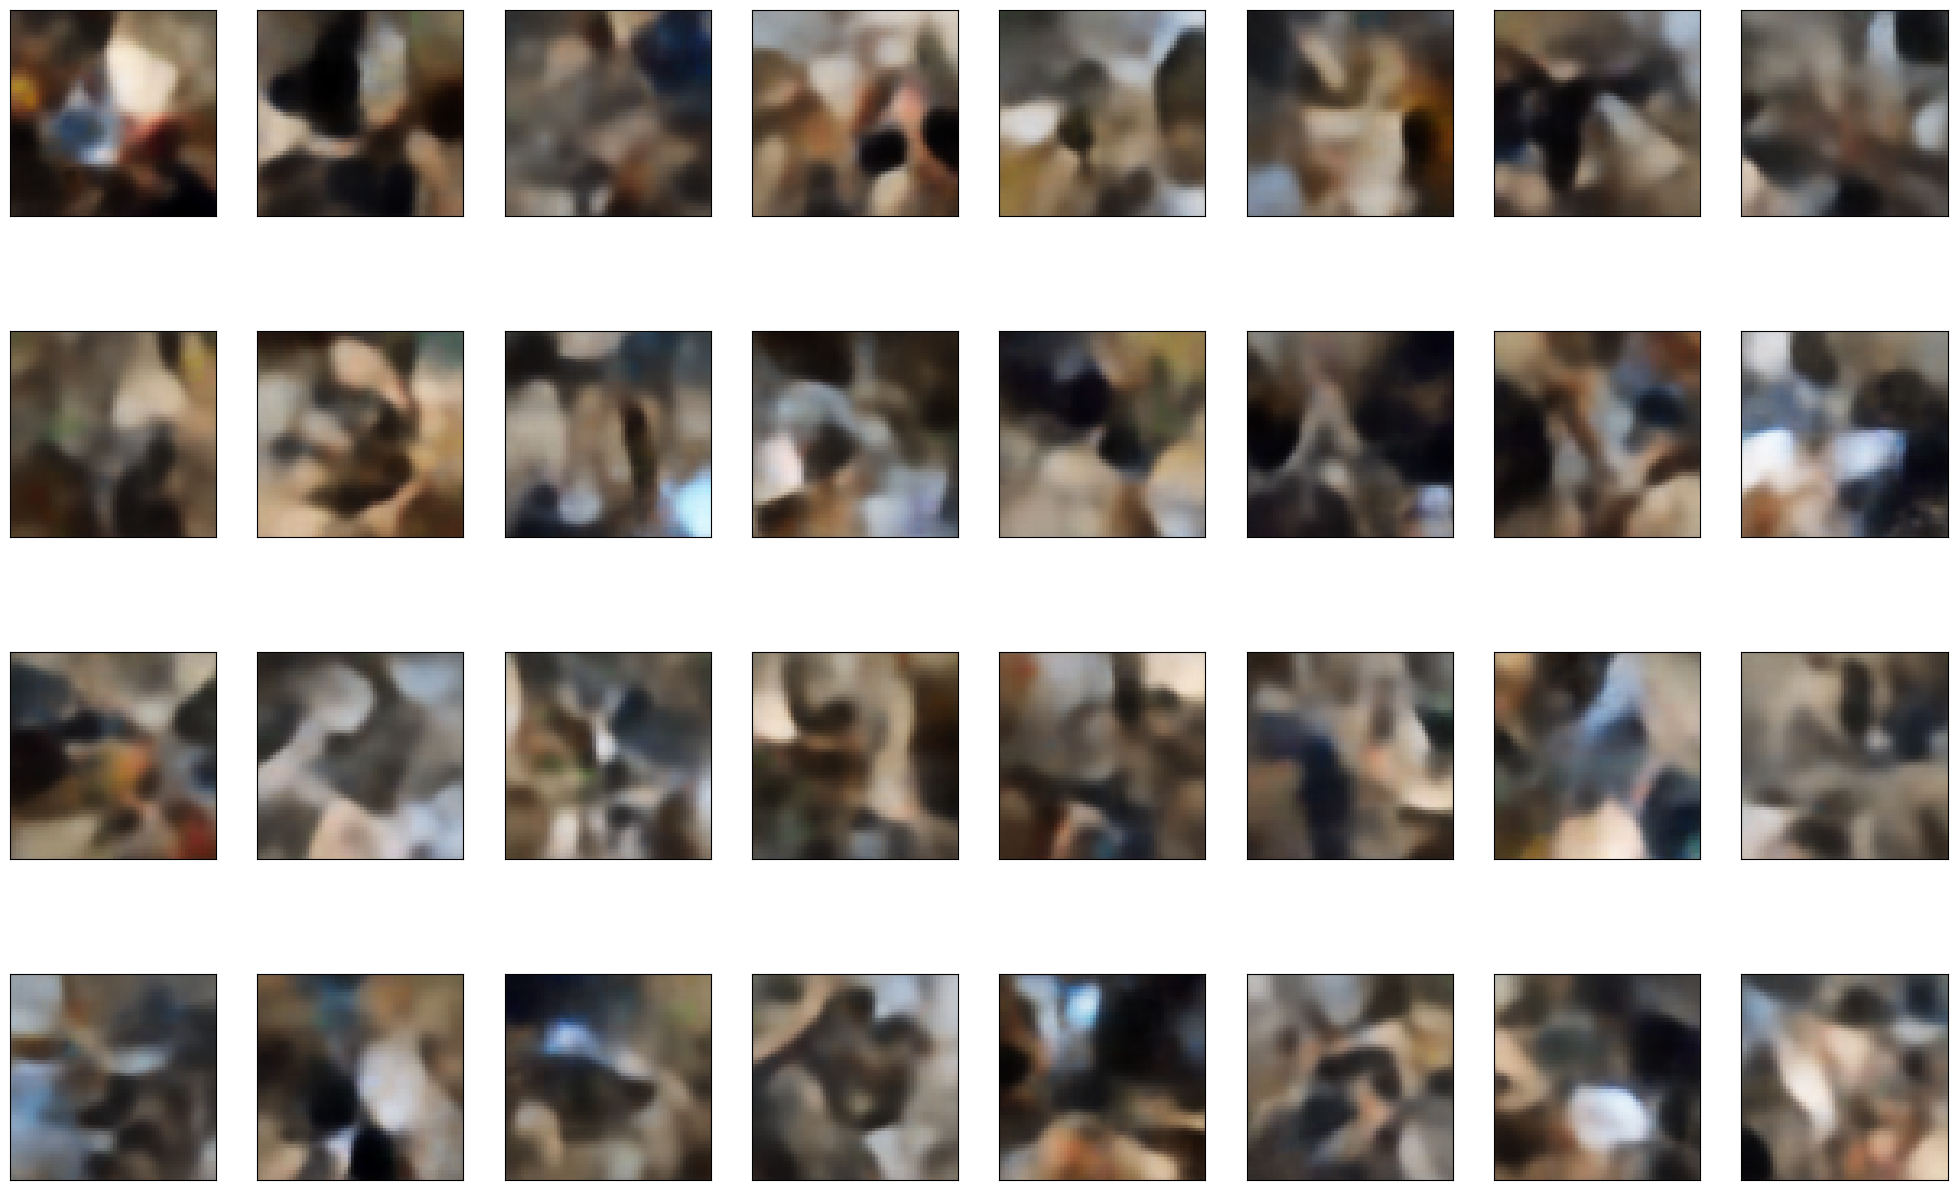

In [18]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))